Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# ResNet on CIFAR10 with Haiku and JAXopt.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jaxopt/blob/main/docs/notebooks/deep_learning/resnet_haiku.ipynb)

In this notebook, we'll go through training a deep residual network with jaxopt.

In [1]:
%%capture
%pip install -U jaxopt dm-haiku dm-tree tqdm

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial

import optax
import tensorflow_datasets as tfds
import tensorflow as tf
import haiku as hk
import tree

from tqdm.auto import trange
from matplotlib import pyplot as plt

import jaxopt
from jaxopt import OptaxSolver

# some typing definitions
from typing import List, Tuple

Batch = List[Tuple[jnp.ndarray, jnp.ndarray]]

# hide the GPU from tensorflow, otherwise it might
# reserve memory on it
tf.config.experimental.set_visible_devices([], "GPU")

# Show on which platform JAX is running.
print("JAX running on", jax.devices()[0].platform.upper())

2023-09-04 11:02:26.459686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


JAX running on GPU


2023-09-04 11:02:28.082145: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# @markdown Total number of epochs to train for:
MAX_EPOCHS = 50  # @param{type:"integer"}
# @markdown Number of samples in each batch:
BATCH_SIZE = 128  # @param{type:"integer"}
# @markdown The initial learning rate for the optimizer:
PEAK_LR = 0.12  # @param{type:"number"}
# @markdown The model architecture for the neural network. Can be one of `'resnet1'`, `'resnet18'`, `'resnet34'`, `'resnet50'`, `'resnet101'`, `'resnet152'` and `'resnet200'`:
MODEL = "resnet18"  # @param{type:"string"}
# @markdown The dataset to use. Could be either `'cifar10'` or `'cifar100'`:
DATASET = "cifar10"  # @param{type:"string"}
# @markdown The amount of L2 regularization (aka weight decay) to use:
L2_REG = 1e-4  # @param{type:"number"}

CIFAR10 and CIFAR100 are composed of 32x32 images with 3 channels (RGB). We'll now load the dataset using `tensorflow_datasets` and display a few of the first samples.

2023-09-04 11:02:29.139890: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


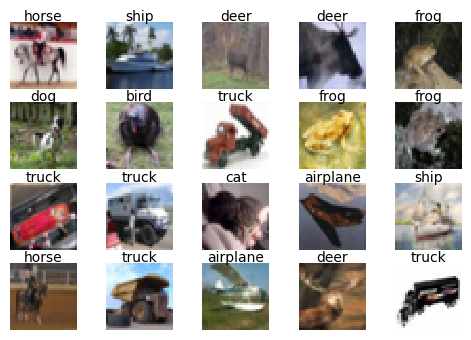

In [4]:
(train_loader, test_loader), info = tfds.load(
    DATASET, split=["train", "test"], as_supervised=True, with_info=True
)
NUM_CLASSES = info.features["label"].num_classes
IMG_SIZE = info.features["image"].shape


def plot_sample_images(loader):
  loader_iter = iter(loader)
  _, axes = plt.subplots(nrows=4, ncols=5, figsize=(6, 4))
  for i in range(4):
    for j in range(5):
      k = i * 4 + j
      image, label = next(loader_iter)
      axes[i, j].imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      axes[i, j].set_axis_off()
      axes[i, j].set_title(info.features["label"].names[label], fontsize=10, y=0.9)


plot_sample_images(train_loader)

The accuracy of the model can be improved significantly through data augmentation. That is, instead of training on the above images, we'll generate random modifications of the images and train on those. This is done by using the `transform` argument of `tfds.load` to apply a random crop, random horizontal flip, and random color jittering.

In the next cell we show an instance of these transformations on the above images.

2023-09-04 11:02:29.976174: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


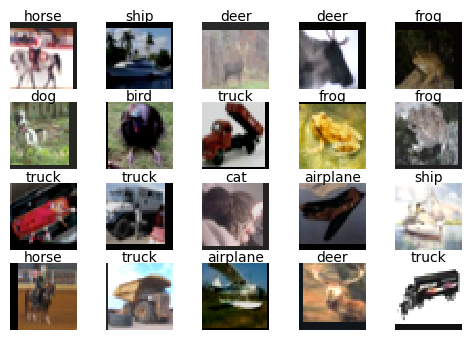

In [5]:
def augment(image, label):
  """Data augmentation for CIFAR10."""
  image = tf.image.resize_with_crop_or_pad(image, 40, 40)
  image = tf.image.random_crop(image, [32, 32, 3])
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, 0.8, 1.2)
  image = tf.image.random_saturation(image, 0.8, 1.2)
  return image, label


train_loader_augmented = train_loader.map(augment)
plot_sample_images(train_loader_augmented)

We now shuffle the data in the train set and create batches of size `'BATCH_SIZE'` for both train and test set

In [6]:
train_loader_batched = train_loader_augmented.shuffle(
    buffer_size=10_000, reshuffle_each_iteration=True
).batch(BATCH_SIZE, drop_remainder=True)

test_loader_batched = test_loader.batch(BATCH_SIZE, drop_remainder=True)

With the data ready, we can now define the model. Below we define the ResNet architecture that we'll later instantiate. We define different variants of the architecture with different sizes and depths (`'ResNet1'`, `'ResNet18'`, `'ResNet34'`, `'ResNet50'` and `'ResNet101'`). The architecture is based on the [Flax imagenet example](https://github.com/google/flax/blob/main/examples/imagenet/models.py).

We'll now load our train and test dataset and plot a few of the training images.

In [7]:
initial_conv_config = {"kernel_shape": (3, 3), "stride": 1, "padding": "SAME"}

RESNET_CONSTRUCTOR = {
    "resnet18": hk.nets.ResNet18,
    "resnet34": hk.nets.ResNet34,
    "resnet50": hk.nets.ResNet50,
    "resnet101": hk.nets.ResNet101,
    "resnet152": hk.nets.ResNet152,
    "resnet200": hk.nets.ResNet200,
}


# haiku definition for the forward pass
@hk.transform_with_state
def net(inputs, is_training):
  inputs = inputs.astype(jnp.float32) / 255.0
  return RESNET_CONSTRUCTOR[MODEL](
      num_classes=NUM_CLASSES, resnet_v2=False, initial_conv_config=initial_conv_config
  )(inputs, is_training=is_training)


logistic_loss = jax.vmap(jaxopt.loss.multiclass_logistic_loss)


@partial(jax.jit, static_argnums=(3,))
def loss_accuracy(
    params: hk.Params,
    net_state: hk.State,
    batch: Batch,
    train: bool = True,
):
  """Compute loss and accuracy over a mini-batch.

  Args:
    params: parameters of the model.
    bn_params: batch normalization parameters.
    batch: tuple of (inputs, labels).
    train: whether to use train mode or eval mode.
  """
  inputs, labels = batch
  logits, net_state = net.apply(params, net_state, None, inputs, is_training=train)
  mean_loss = jnp.mean(logistic_loss(labels, logits))
  accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
  # make sure batchnorm parameters are not regularized
  l2_params = [
      p
      for ((mod_name, _), p) in tree.flatten_with_path(params)
      if "batchnorm" not in mod_name
  ]
  sqnorm = jaxopt.tree_util.tree_l2_norm(l2_params, squared=True)
  loss = mean_loss + 0.5 * L2_REG * sqnorm
  return loss, {"accuracy": accuracy, "net_state": net_state}

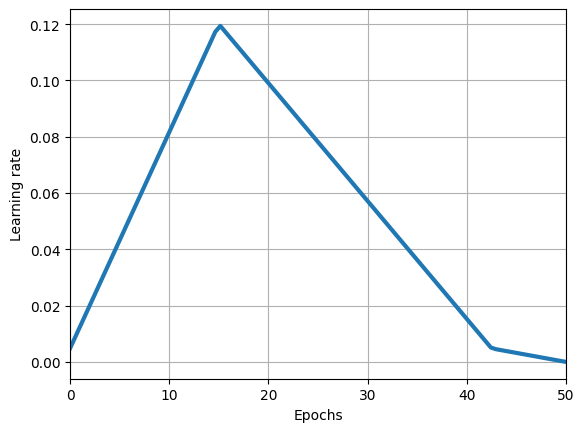

In [8]:
iter_per_epoch_train = info.splits["train"].num_examples // BATCH_SIZE
lr_schedule = optax.linear_onecycle_schedule(MAX_EPOCHS * iter_per_epoch_train, 0.12)

iterate_subsample = np.linspace(0, MAX_EPOCHS * iter_per_epoch_train, 100)
plt.plot(
    np.linspace(0, MAX_EPOCHS, len(iterate_subsample)),
    [lr_schedule(i) for i in iterate_subsample],
    lw=3,
)
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.grid()
plt.xlim((0, MAX_EPOCHS))
plt.show()

In the next two cells we'll initialize the variables and states. We also define a convenience function `dataset_stats` that we'll call once per epoch to collect the loss and accuracy of our solver over the test set.

In [9]:
opt = optax.sgd(lr_schedule, momentum=0.9, nesterov=False)

# We need has_aux=True because loss_fun returns batch_stats.
solver = OptaxSolver(
    opt=opt, fun=loss_accuracy, maxiter=MAX_EPOCHS * iter_per_epoch_train, has_aux=True
)

# Initialize parameters.
rng = jax.random.PRNGKey(0)
dummy_data = jnp.ones((1,) + IMG_SIZE, dtype=jnp.float32)
dummy_targets = jnp.ones(1, int)
var_params, var_net_state = net.init(rng, dummy_data, is_training=True)

In [10]:
# Define parameter update function
solver_state = solver.init_state(
    var_params, var_net_state, (dummy_data, dummy_targets)
)


def dataset_stats(params, net_state, data_loader):
  """Compute loss and accuracy over the dataset `data_loader` for `max_iter` items."""
  all_accuracy = []
  all_loss = []
  for batch in data_loader.as_numpy_iterator():
    loss, aux = loss_accuracy(params, net_state, batch, train=False)
    all_accuracy.append(aux["accuracy"])
    all_loss.append(loss)
  return {"loss": np.mean(all_loss), "accuracy": np.mean(all_accuracy)}

Finally, we do the actual training. The next cell performs `'MAX_EPOCHS'` epochs of training. Within each epoch we iterate over the batched loader `train_loader_batched`, and once per epoch we also compute the test set accuracy and loss.

In [11]:
train_accuracy = []
train_loss = []
# Compute test set accuracy at initialization
test_stats = dataset_stats(var_params, var_net_state, test_loader_batched)
test_accuracy = [test_stats["accuracy"]]
test_loss = [test_stats["loss"]]

# Training loop.

pbar = trange(MAX_EPOCHS, desc="Training progress", leave=True, unit="epochs")
for epoch in pbar:
  train_accuracy_epoch = []
  train_loss_epoch = []

  for batch in train_loader_batched.as_numpy_iterator():
    var_params, solver_state = solver.update(
        params=var_params, state=solver_state, net_state=var_net_state, batch=batch
    )
    var_net_state = solver_state.aux["net_state"]
    train_accuracy_epoch.append(solver_state.aux["accuracy"])
    train_loss_epoch.append(solver_state.value)

  # once per epoch, make a pass over the test set to compute accuracy
  test_stats = dataset_stats(var_params, var_net_state, test_loader_batched)
  test_accuracy.append(test_stats["accuracy"])
  test_loss.append(test_stats["loss"])
  train_accuracy.append(np.mean(train_accuracy_epoch))
  train_loss.append(np.mean(train_loss_epoch))

  # update progress bar
  pbar.set_postfix({
      "test set accuracy": test_accuracy[-1],
      "train set accuracy": np.mean(train_accuracy_epoch),
  })

Training progress:   0%|          | 0/50 [00:00<?, ?epochs/s]

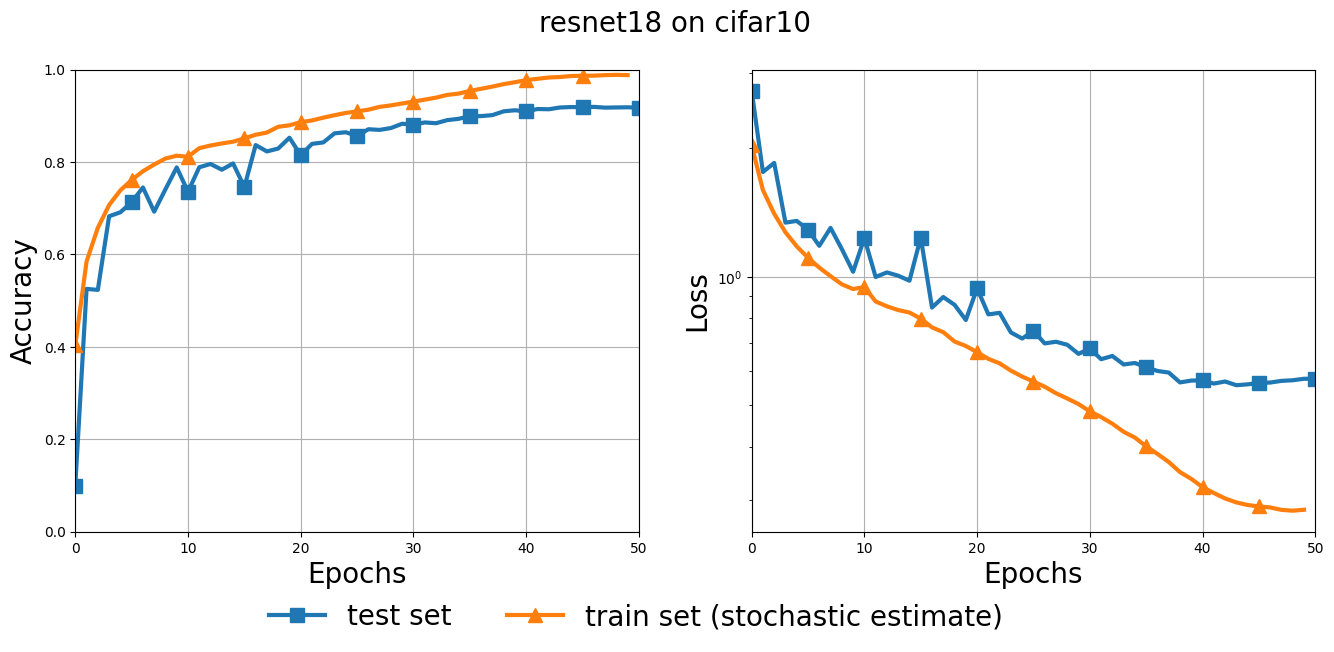

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plt.suptitle(f"{MODEL} on {DATASET}", fontsize=20)

ax1.plot(test_accuracy, lw=3, marker="s", markevery=5, markersize=10, label="test set")
ax1.plot(
    train_accuracy,
    lw=3,
    marker="^",
    markevery=5,
    markersize=10,
    label="train set (stochastic estimate)",
)
ax1.set_ylabel("Accuracy", fontsize=20)
ax1.grid()
ax1.set_xlabel("Epochs", fontsize=20)
ax1.set_xlim((0, MAX_EPOCHS))
ax1.set_ylim((0, 1))

ax2.plot(test_loss, lw=3, marker="s", markevery=5, markersize=10, label="test set")
ax2.plot(
    train_loss,
    lw=3,
    marker="^",
    markevery=5,
    markersize=10,
    label="train set (stochastic estimate)",
)
ax2.set_ylabel("Loss", fontsize=20)
ax2.grid()
ax2.set_xlabel("Epochs", fontsize=20)
ax2.set_xlim((0, MAX_EPOCHS))

# set legend at the bottom of the plot
ax1.legend(frameon=False, fontsize=20, ncol=2, loc=2, bbox_to_anchor=(0.3, -0.1))

ax2.set_yscale("log")

plt.show()

In [13]:
# Finally, let's print the test
print("Final accuracy on test set: ", test_accuracy[-1])

Final accuracy on test set:  0.9177684
